# Plots for Needle in Haystack Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'Times New Roman'

import logging
import pickle
from datetime import datetime
import os
from data_processing import gen_ckpt_steps
from conv_plots_funcs import get_seg_starts_per_config
import torch
import gc

/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda


#### Experiment Details

In [110]:
valA = "gaussA"
valC = "_gauss_C"
state_dim = 5
ckpt_step = 141000
experiment = "250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = False

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
errs_loc = errs_dir + f"/needle_{datasource}_" + f"{valA}_state_dim_{state_dim}_"
seg_ext_errs_loc = errs_dir + f"/needle_{datasource}_fin_seg_ext_" + f"{valA}_state_dim_{state_dim}_"


quartiles_file = model_dir + experiment + "/needles/quartiles.npz"

seg_ext_quartiles_file = model_dir + experiment + "/needles/seg_ext_quartiles.npz"

if os.path.exists(quartiles_file):
    print(f"Loading quartiles from {quartiles_file}")
    quartiles = np.load(quartiles_file)

if os.path.exists(seg_ext_quartiles_file):
    print(f"Loading seg ext quartiles from {seg_ext_quartiles_file}")
    seg_ext_quartiles = np.load(seg_ext_quartiles_file)


print(f"Errors location: {errs_loc}")

Loading quartiles from ../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/quartiles.npz
Loading seg ext quartiles from ../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/seg_ext_quartiles.npz
Errors location: ../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=141000.ckpt/needle_val_gaussA_state_dim_5_


#### load the err_lss_examples at path which is numpy array

In [15]:
with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
    err_lss_examples = pickle.load(f)

with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
    seg_ext_err_lss_examples = pickle.load(f)

In [16]:
for key in err_lss_examples.keys():
    print(f"shape of examples[{key}]: {err_lss_examples[key].shape}")

for key in seg_ext_err_lss_examples.keys():
    print(f"shape of seg_ext_examples[{key}]: {seg_ext_err_lss_examples[key].shape}")

shape of examples[MOP]: (200, 19, 2000, 251)
shape of examples[Zero]: (200, 19, 2000, 251)
shape of examples[Kalman_rem]: (200, 19, 2000, 251)
shape of examples[Analytical_Kalman]: (200, 19, 251)
shape of examples[Analytical_Simulation]: (200, 19, 2000, 251)
shape of examples[OLS_ir_1]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_1]: (200, 19, 2000, 251)
shape of examples[OLS_ir_2]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_2]: (200, 19, 2000, 251)
shape of examples[OLS_ir_3]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_3]: (200, 19, 2000, 251)
shape of seg_ext_examples[MOP]: (200, 1, 2000, 251)
shape of seg_ext_examples[Zero]: (200, 1, 2000, 251)
shape of seg_ext_examples[Kalman_rem]: (200, 1, 2000, 251)
shape of seg_ext_examples[Analytical_Kalman]: (200, 1, 251)
shape of seg_ext_examples[Analytical_Simulation]: (200, 1, 2000, 251)
shape of seg_ext_examples[OLS_ir_1]: (200, 1, 2000, 251)
shape of seg_ext_examples[OLS_analytical_ir_1]: (200, 1, 

#### Compute the Quartiles

In [3]:
def comp_quartiles(err_lss_examples, ratio=False, train_conv=False, kal_err=None):
    quartiles = {}
    if ratio:
        if not train_conv:
            kal_err = err_lss_examples["Kalman_rem"]

    for key in err_lss_examples.keys():
        if not (key == "Analytical_Kalman" or key == "Kalman_rem" or key == "Kalman"):
            if ratio:
                rat = err_lss_examples[key] / kal_err
            else:
                rat = err_lss_examples[key]
            med = np.median(rat, axis=2)
            # print(f"shape of med: {med.shape}")
            quartiles[key] = np.percentile(med, [25,50,75], axis=0)
            # print(f"shape of quartiles[{key}]: {quartiles[key].shape}")
            
    return quartiles


In [18]:
if valA == "gaussA":
    rat = True
else:
    rat = False
quartiles = comp_quartiles(err_lss_examples, ratio=rat)

#save quartiles to npz file
os.makedirs(os.path.dirname(quartiles_file), exist_ok=True)
np.savez(quartiles_file, **quartiles)

/tmp/ipykernel_770068/341765924.py:11: RuntimeWarning: invalid value encountered in divide
  rat = err_lss_examples[key] / kal_err


shape of med: (200, 19, 251)
shape of quartiles[MOP]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[Zero]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[Analytical_Simulation]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_1]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_1]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_2]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_2]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_3]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_3]: (3, 19, 251)


In [19]:
seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)

#save seg_ext_quartiles to npz file
os.makedirs(os.path.dirname(seg_ext_quartiles_file), exist_ok=True)
np.savez(seg_ext_quartiles_file, **seg_ext_quartiles)

/tmp/ipykernel_770068/341765924.py:11: RuntimeWarning: invalid value encountered in divide
  rat = err_lss_examples[key] / kal_err


shape of med: (200, 1, 251)
shape of quartiles[MOP]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[Zero]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[Analytical_Simulation]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_1]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_1]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_2]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_2]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_3]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_3]: (3, 1, 251)


## Plotting Code

### final trace

In [4]:
haystack_len = quartiles["MOP"].shape[1]

print(f"quartiles[mop] shape: {quartiles['MOP'].shape}, seg_ext_quartiles[mop] shape: {seg_ext_quartiles['MOP'].shape}")

print(f"haystack_len: {haystack_len}")

quartiles[mop] shape: (3, 19, 251), seg_ext_quartiles[mop] shape: (3, 1, 251)
haystack_len: 19


real_steps: [230, 231, 232, 234, 239], real_steps_ext: [228, 229, 230, 232, 237]
key_count: 0
needle: 0, step: 1, real_step: 230
y: 0.016245415434241295
needle: 0, step: 2, real_step: 231
y: 0.0821661427617073
needle: 0, step: 3, real_step: 232
y: 0.0395442359149456
needle: 0, step: 5, real_step: 234
y: 0.025576048530638218
needle: 0, step: 10, real_step: 239
y: 0.004009387455880642
key_count: 1
needle: 0, step: 1, real_step: 230
y: 0.8684388399124146
needle: 0, step: 2, real_step: 231
y: 0.8684388399124146
needle: 0, step: 3, real_step: 232
y: 0.8684388399124146
needle: 0, step: 5, real_step: 234
y: 0.8684388399124146
needle: 0, step: 10, real_step: 239
y: 0.8684388399124146
key_count: 0
needle: 1, step: 1, real_step: 230
y: 0.015335557516664267
needle: 1, step: 2, real_step: 231
y: 0.08899160474538803
needle: 1, step: 3, real_step: 232
y: 0.04119935259222984
needle: 1, step: 5, real_step: 234
y: 0.02409233432263136
needle: 1, step: 10, real_step: 239
y: 0.004135136026889086
key_count

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


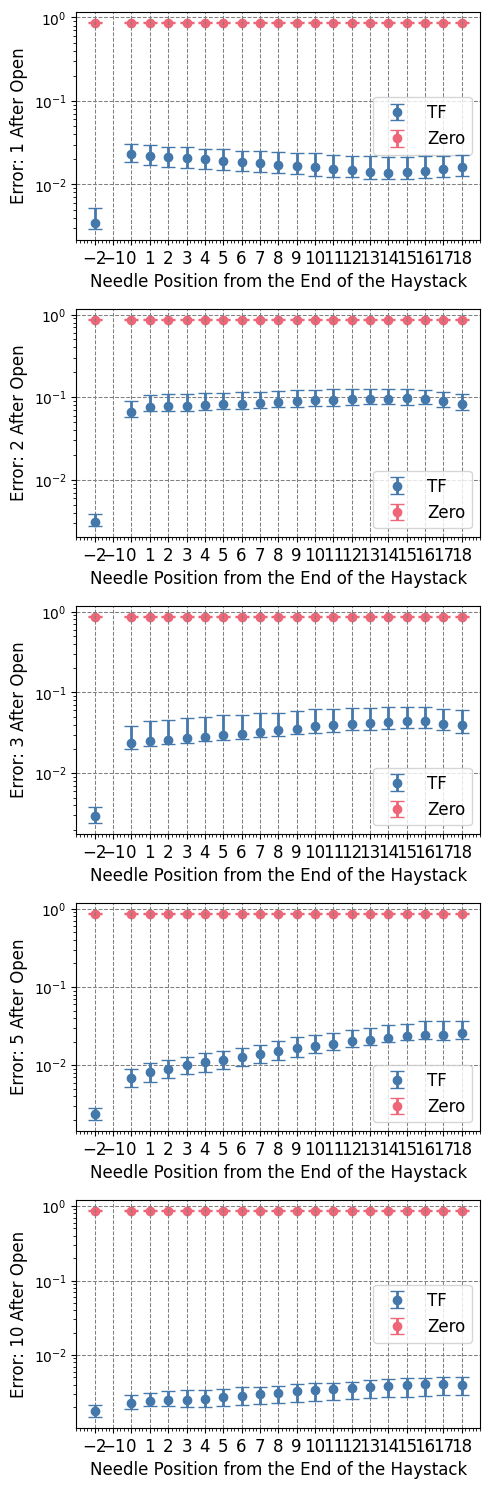

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


In [5]:
steps_in = [1,2,3,5,10]
open_paren_ind = 229
real_steps = [x + open_paren_ind for x in steps_in]
real_steps_ext = [x + open_paren_ind-2 for x in steps_in]

fig, ax = plt.subplots(len(steps_in), 1, sharex=True, figsize=(5, 3*len(steps_in)))

#get a high contrast color map
colors = ["#4477AA", "#EE6677", "#228833", "#CCBB44", "#66CCEE"]

print(f"real_steps: {real_steps}, real_steps_ext: {real_steps_ext}")


for needle in range(haystack_len):
    key_count = 0
    for key in quartiles.keys():
        print(f"key_count: {key_count}")
        if "OLS_analytical" not in key and "Simulation" not in key:
            # ax[needle].scatter(quartiles[key][1, needle], label=key)
            step_count = 0
            for step in steps_in:

                key_label = "TF" if key == "MOP" else key

                print(f"needle: {needle}, step: {step}, real_step: {real_steps[step_count]}")

                y = quartiles[key][1, needle, real_steps[step_count]]
                print(f"y: {y}")
                if valA == "gaussA":
                    y -= 1
                yerr = [
                    quartiles[key][1, needle, real_steps[step_count]] - quartiles[key][0, needle, real_steps[step_count]],
                    quartiles[key][2, needle, real_steps[step_count]] - quartiles[key][1, needle, real_steps[step_count]]
                ]#

                yerr = np.array([[yerr[0]], [yerr[1]]])

                ax[step_count].errorbar(
                    haystack_len - needle - 1,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label=f"{key_label}" if needle == 0 else "_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color=colors[key_count],
                    linewidth=2
                )

                step_count += 1
            key_count += 1

key_count = 0
for key in seg_ext_quartiles.keys():
    if "OLS_analytical" not in key and "Simulation" not in key:
        step_count = 0
        for step in steps_in:
            y = seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            if valA == "gaussA":
                y -= 1
            yerr = [
                seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][0, 0, real_steps_ext[step_count]],
                seg_ext_quartiles[key][2, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            ]

            yerr = np.array([[yerr[0]], [yerr[1]]])
            
            ax[step_count].errorbar(
                -2,
                y,
                yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                fmt='o',
                label="_nolegend_",
                capsize=5,
                zorder=haystack_len if key == "MOP" else 0, color = colors[key_count], 
                linewidth=2
            )

            ax[step_count].legend(fontsize = 12)
            ax[step_count].set_xlabel("Needle Position from the End of the Haystack", fontsize=12, fontname="Times New Roman")
            ax[step_count].set_ylabel(("(" if valA== "gaussA" else "") + "Error" + (" / Emp KF Error)" if valA == "gaussA" else "") + f": {step} After Open", fontsize=12)
            ax[step_count].set_xlim(-3, haystack_len)
            ax[step_count].grid(True)
            ax[step_count].minorticks_on()
            ax[step_count].grid(which='major', linestyle='--', linewidth='0.75', color='gray')
            # ax[step_count].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
            #set the grid to be on integer values for x-axis
            ax[step_count].set_xticks(np.arange(-2, haystack_len, 1))
            ax[step_count].set_yscale('log')
            # ax[step_count].set_ylim(0.3, 3)
            ax[step_count].tick_params(axis='x', which='both', labelbottom=True, labelsize=12)

            step_count += 1
        key_count += 1


fig.tight_layout()

plt.show()

os.makedirs(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}", exist_ok=True)
fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}/error_ratios_{valA}_state_dim_{state_dim}{valC}_step_{ckpt_step}.pdf", transparent=True)



In [114]:
if valA == "gaussA":
    quartilez_npz = quartiles
    seg_ext_quartiles_npz = seg_ext_quartiles
    quartiles = {key: quartiles[key] for key in quartiles.keys()}
    seg_ext_quartiles = {key: seg_ext_quartiles_npz[key] for key in seg_ext_quartiles_npz.keys()}
    for key in quartiles.keys():
        seg_ext_quartiles[key] -= 1
        quartiles[key] -= 1

haystack_len: 19


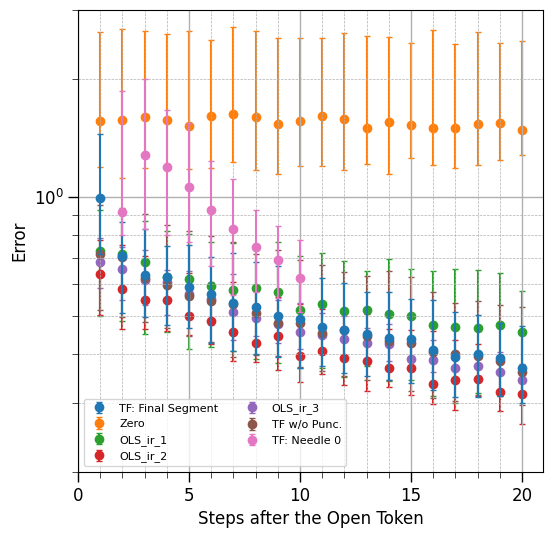

In [123]:
#make a figure with haystack_len subplots
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
# fig, ax = plt.subplots(haystack_len, 1, sharex=True, figsize=(5, 5*haystack_len))

open_paren_ind = 229
fin_seg_len = 250-open_paren_ind -1
x_values = np.arange(1, fin_seg_len+1)

print(f"haystack_len: {haystack_len}")
ax_count = 0
needle = haystack_len - 1
for key in quartiles.keys():
    if "OLS_analytical" not in key and "Simulation" not in key:

        ax.errorbar(x_values, quartiles[key][1, needle][open_paren_ind+1:-1], yerr=[quartiles[key][1, needle][open_paren_ind+1:-1] - quartiles[key][0, needle][open_paren_ind+1:-1], quartiles[key][2, needle][open_paren_ind+1:-1] - quartiles[key][1, needle][open_paren_ind+1:-1]], fmt='o', label="TF: Final Segment" if key == "MOP" else f"{key}", capsize=2, zorder=haystack_len if key == "MOP" else 0)

needle = 0
# for key in seg_ext_quartiles.keys():
#     if "OLS_analytical" not in key:



y_values = seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]
yerr_lower = seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len] - seg_ext_quartiles["MOP"][0, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]
yerr_upper = seg_ext_quartiles["MOP"][2, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len] - seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]

ax.errorbar(x_values, y_values, yerr=[yerr_lower, yerr_upper], fmt='o', label=f"TF w/o Punc.", capsize=2, zorder=haystack_len if key == "MOP" else 0)

needle = 0 #get the first needle
open_paren_ind = 1
key = "MOP"

fin_seg_len = 10

ax.errorbar(x_values[:10], quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len], yerr=[quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len] - quartiles[key][0, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len], quartiles[key][2, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len] - quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len]], fmt='o', label="TF: Needle 0", capsize=2, zorder=haystack_len if key == "MOP" else 0)
        
ax.legend(ncol=2 if valA == "gaussA" else 1, fontsize=8)
ax.grid(which="both")
# ax.set_xlim(left=230, right=seg_ext_quartiles[key].shape[-1] - 1)  # set the x axis limits haystack_len*12 + 2
# ax.set_ylim(bottom=0, top=5.5)  # set the y axis limits

# Optionally, customize major and minor ticks
ax.minorticks_on()

# Set minor vertical grid lines to be on intervals of 1
# Set major ticks on every interval of 50
ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 5))

# Set minor vertical grid lines to be on intervals of 1
ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 1), minor=True)

ax.tick_params(axis='both', which='major', length=7, width=1, labelsize=12)
ax.tick_params(axis='both', which='minor', length=4, width=0.5, labelsize=0)
ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=12)
ax.grid(which='major', linestyle='-', linewidth=1)
ax.grid(which='minor', linestyle='--', linewidth=0.5)
ax.set_ylabel(f"Error", fontsize=12)
ax.set_xlabel("Steps after the Open Token", fontsize=12)
ax.set_yscale('log')
# ax.set_title(f"Prediction Error for Needle Position {needle}", fontsize=30)
if valA == "gaussA":
    ax.set_ylim([2e-1, 3])

#add the date and time to the filename
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# #add a caption to the bottom of the figure
# fig.text(0.5, 0.1, f"Median of {num_examples} haystack configuration examples. step=" + str(ckpt_step) + "_" + timestamp, ha='center', fontsize=30)

# Needle in a Haystack: Training Convergence

In [58]:
minval = 100
maxval = 26000
interval = 100
ckpt_steps = gen_ckpt_steps(minval, maxval, interval)
batch_size = 512
gpus=2

kal_ckpt = 126000

if valA == "gaussA":
    rat = True
else:
    rat = False

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

haystack_len = 19

train_conv_fin_quartiles_file = model_dir + experiment + f"/needles/train_conv/train_conv_fin_quartiles_haystack_len_{haystack_len}.npz"
train_conv_beg_quartiles_file = model_dir + experiment + f"/needles/train_conv/train_conv_beg_quartiles_haystack_len_{haystack_len}.npz"
x_values_file = model_dir + experiment + f"/needles/train_conv/x_values_haystack_len_{haystack_len}.npy"



if os.path.exists(train_conv_fin_quartiles_file):
    print(f"Loading train conv quartiles from {train_conv_fin_quartiles_file}")
    fin_quartiles = np.load(train_conv_fin_quartiles_file, allow_pickle=True)
    fin_quartiles_ckpt = {}
    for key in fin_quartiles_ckpt.keys():
        fin_quartiles_ckpt[key] = fin_quartiles[key]

if os.path.exists(train_conv_beg_quartiles_file):
    print(f"Loading train conv quartiles from {train_conv_beg_quartiles_file}")
    beg_quartiles = np.load(train_conv_beg_quartiles_file, allow_pickle=True)
    beg_quartiles_ckpt = {}
    for key in beg_quartiles_ckpt.keys():
        beg_quartiles_ckpt[key] = beg_quartiles[key]

if os.path.exists(x_values_file):
    x_values = np.load(x_values_file)

ckpt_steps: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, 10100, 10200, 10300, 10400, 10500, 10600, 10700, 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700, 11800, 11900, 12000, 12100, 12200, 12300, 12400, 12500, 12600, 12700, 12800, 12900, 13000, 13100, 13200, 13300, 13400, 13500, 13600, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400, 14500, 14600, 14700, 14800, 14900, 15000, 15100, 15200, 15300, 15400, 15500, 15600, 157

path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=100.ckpt/train_conv_needle_haystack_len_19_val_ident_state_dim_5_err_lss_examples for ckpt_step: 100 does not exist.
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=200.ckpt/train_conv_needle_haystack_len_19_val_ident_state_dim_5_err_lss_examples for ckpt_step: 200 does not exist.
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=300.ckpt/train_conv_needle_haystack_len_19_val_ident_state_dim_5_err_lss_examples for ckpt_step: 300 does not exist.
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=400.c

/home/sultand/.local/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


batch_size: 512, gpus: 2, ckpt_step: 1500, last_pred_ckpt: 0
x_value: 1536000
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=1600.ckpt/train_conv_needle_haystack_len_19_val_ident_state_dim_5_err_lss_examples for ckpt_step: 1600 does not exist.
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=1700.ckpt/train_conv_needle_haystack_len_19_val_ident_state_dim_5_err_lss_examples for ckpt_step: 1700 does not exist.
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=1800.ckpt/train_conv_needle_haystack_len_19_val_ident_state_dim_5_err_lss_examples for ckpt_step: 1800 does not exist.
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident

/tmp/ipykernel_1848178/1828519536.py:133: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[needle].legend(fontsize=8)


batch_size: 512, gpus: 2, ckpt_step: 2400, last_pred_ckpt: 1500
x_value: 2457600
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=2500.ckpt/train_conv_needle_haystack_len_19_val_ident_state_dim_5_err_lss_examples for ckpt_step: 2500 does not exist.
loading errors for ckpt_step: 2600
batch_size: 512, gpus: 2, ckpt_step: 2600, last_pred_ckpt: 2400
x_value: 2662400
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=2700.ckpt/train_conv_needle_haystack_len_19_val_ident_state_dim_5_err_lss_examples for ckpt_step: 2700 does not exist.
path: ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=2800.ckpt/train_conv_needle_haystack_len_19_val_ident_state_dim_5_err_lss_examples

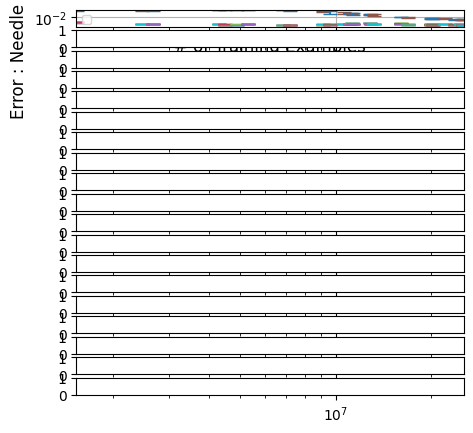

In [61]:
steps_in = [1,2,3,5,10]

fig, ax = plt.subplots(max(2,haystack_len), 1, sharex=True, figsize=(5, 5))


quartiles_ckpt = []
pred_ckpts = []
last_pred_ckpt = 0
x_values = []
ys = {}
y_errs = {}
fin_quartiles_ckpt = {}
beg_quartiles_ckpt = {}

if valA == "gaussA":
    errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={kal_ckpt}.ckpt"
    # errs_loc = errs_dir + f"/single_system_" + f"{valA}_state_dim_{state_dim}_" 
    errs_loc = errs_dir + f"/train_conv_needle_haystack_len_{haystack_len}_{datasource}_" + f"{valA}_state_dim_{state_dim}_"

    with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
            kal_ckpt_errs = pickle.load(f)

    kal_err = kal_ckpt_errs["Kalman_rem"]

for ckpt_step in ckpt_steps:

    errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
    errs_loc = errs_dir + f"/single_system_" + f"{valA}_state_dim_{state_dim}_"
    errs_loc = errs_dir + f"/train_conv_needle_haystack_len_{haystack_len}_{datasource}_" + f"{valA}_state_dim_{state_dim}_" 

    if os.path.exists(errs_loc + "err_lss_examples.pkl"):
        print(f"loading errors for ckpt_step: {ckpt_step}")

        if len(pred_ckpts) > 0:
            last_pred_ckpt = pred_ckpts[-1]
            
            if valA == "ortho":
                gpus = 2 #just for ortho case

        else:
            last_pred_ckpt = 0
            if valA == "ortho":
                gpus = 3

        with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
            err_lss_examples = pickle.load(f)

        # if os.path.exists(seg_ext_errs_loc + "err_lss_examples.pkl"):
        #     with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
        #         seg_ext_err_lss_examples = pickle.load(f)

        if len(pred_ckpts) == 0:
            #get seg_starts
            seg_starts_per_conf = get_seg_starts_per_config(experiment, valA, valC, state_dim, ckpt_step, print_seg_starts=True, nope=nope, needle=True, haystack_len=haystack_len, train_conv=True)

        quartiles = comp_quartiles(err_lss_examples, ratio=rat, train_conv=True, kal_err=kal_err)

        del err_lss_examples
        #clear cuda cache
        torch.cuda.empty_cache()
        gc.collect()

        print(f"batch_size: {batch_size}, gpus: {gpus}, ckpt_step: {ckpt_step}, last_pred_ckpt: {last_pred_ckpt}")
        if len(x_values) > 0:
            x_value = batch_size*gpus*(ckpt_step - last_pred_ckpt) + x_values[-1]
        else:
            x_value = batch_size*gpus*(ckpt_step - last_pred_ckpt)

        print(f"x_value: {x_value}")
        x_values.append(x_value)
        for needle in range(1):
            fin_seg_start = seg_starts_per_conf[needle][-1]
            beg_seg_start = seg_starts_per_conf[needle][0]
            for step in steps_in:
                for key in ["MOP"]:
                    if "OLS_analytical" not in key and key not in  ["Zero", "Analytical_Simulation", "Kalman_rem", "Kalman", "Analytical_Kalman"]:
                        key_lab = "TF" if key == "MOP" else key
                        
                        y = quartiles[key][1, needle, fin_seg_start + step]
                        
                        y_err = [
                            [quartiles[key][1, needle, fin_seg_start + step] - quartiles[key][0, needle, fin_seg_start + step]],
                            [quartiles[key][2, needle, fin_seg_start + step] - quartiles[key][1, needle, fin_seg_start + step]]
                        ]

                        if needle == 0:
                            if len(pred_ckpts) == 0:
                                if step == 1:
                                    ys[key] = {}
                                    y_errs[key] = {}
                                    fin_quartiles_ckpt[key] = {}
                                    beg_quartiles_ckpt[key] = {}

                                    # for ir in range(1,4):
                                    #     ys[f"OLS_ir_{ir}"] = {}
                                    #     y_errs[f"OLS_ir_{ir}"] = {}
                                    #     fin_quartiles_ckpt[f"OLS_ir_{ir}"] = {}
                                    #     beg_quartiles_ckpt[f"OLS_ir_{ir}"] = {}


                                # print("step: ", step)
                                # print(f"key: {key}, step: {step}")
                                ys[key][step] = [y]
                                y_errs[key][step] = [y_err]
                                fin_quartiles_ckpt[key][step] = [quartiles[key][:, needle, fin_seg_start + step]]
                                beg_quartiles_ckpt[key][step] = [quartiles[key][:, needle, beg_seg_start + step]]

                            # elif ckpt_step == kal_ckpt and "OLS" in key:
                            #     ys[key][step] = [y]
                            #     y_errs[key][step] = [y_err]
                            #     fin_quartiles_ckpt[key][step] = [quartiles[key][:, needle, fin_seg_start + step]]
                            #     beg_quartiles_ckpt[key][step] = [quartiles[key][:, needle, beg_seg_start + step]]

                                # print(f"ys: {ys}")
                            else:
                                # print(f"ys: {ys}")
                                # print("step after minval: ", step)
                                # print(f"ys: {ys}")
                                # print(f"key: {key}, step: {step}")
                                ys[key][step].append(y)
                                y_errs[key][step].append(y_err)
                                fin_quartiles_ckpt[key][step].append(quartiles[key][:, needle, fin_seg_start + step])
                                beg_quartiles_ckpt[key][step].append(quartiles[key][:, needle, beg_seg_start + step])

                        ax[needle].errorbar(x_value, y, y_err, label=f"{key}: {step} after open" if ckpt_step == minval else "_nolegend_", capsize=5, markersize=5)

            
            ax[needle].set_xlabel("# of Training Examples", fontsize=12)
            ax[needle].set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else "") + f": Needle Position {needle}", fontsize=12)
            ax[needle].set_yscale('log')
            ax[needle].set_xscale('log')
            ax[needle].grid(True)
            ax[needle].legend(fontsize=8)
            ax[needle].set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)

        pred_ckpts.append(ckpt_step)
    else:
        print(f"path: {errs_loc + "err_lss_examples"} for ckpt_step: {ckpt_step} does not exist.")
   
plt.show()


os.makedirs(os.path.dirname(train_conv_fin_quartiles_file), exist_ok=True)
np.savez(train_conv_fin_quartiles_file, **fin_quartiles_ckpt)

os.makedirs(os.path.dirname(train_conv_beg_quartiles_file), exist_ok=True)
np.savez(train_conv_beg_quartiles_file, **beg_quartiles_ckpt)

os.makedirs(os.path.dirname(x_values_file), exist_ok=True)
np.save(x_values_file, x_values)


        # seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)


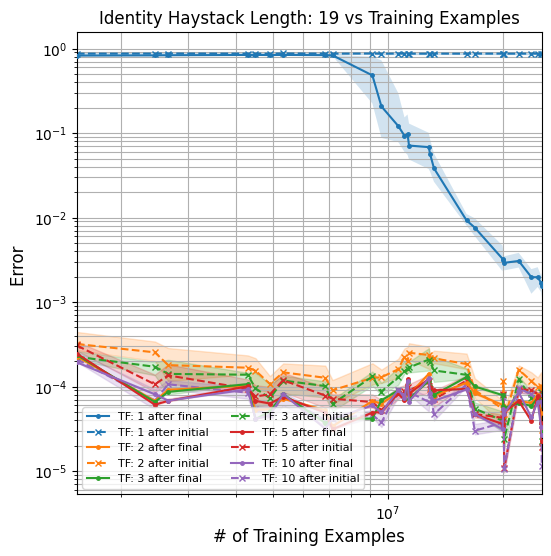

In [62]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))

for key in fin_quartiles_ckpt.keys():
    if key == "MOP":
        for step in fin_quartiles_ckpt[key].keys():

            key_lab = "TF" if key == "MOP" else key
            qs = np.array(fin_quartiles_ckpt[key][step])
            qs = np.transpose(qs)

            if valA == "gaussA":
                qs -= 1

            #if key contains OLS then repeat the values in qs to be the length of x_values
            if "OLS" in key:
                print(f"key: {key} qs shape: {qs.shape}")
                qs = np.repeat(qs, len(x_values), axis=0)
                print(f"qs shape after repeat: {qs.shape}")
            ax.plot(x_values, qs[1], label=f"{key_lab}: {step} after final", markersize=5, marker=".", zorder=5 if key == "MOP" else 0)
            ax.fill_between(x_values, qs[0], qs[2], alpha=0.2)

            beg_qs = np.array(beg_quartiles_ckpt[key][step])
            beg_qs = np.transpose(beg_qs)
            #set the color to the same as the fin quartiles
            color = ax.get_lines()[-1].get_color()
            ax.plot(x_values, beg_qs[1], label=f"{key_lab}: {step} after initial", markersize=5, marker="x", color=color, linestyle="--")
            ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)


ax.set_xlabel("# of Training Examples", fontsize=12)
ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else ""), fontsize=12)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True, which="both")
ax.legend(fontsize=8, loc="lower left", ncol=2 if valA =="ident" else 1)
ax.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
# ax.set_ylim([1e-1, 5])
ax.set_title(("Ortho" if valA == "ortho" else ("Gaussian" if valA == "gaussA" else "Identity")) + f" Haystack Length: {haystack_len} vs Training Examples")
# plt.tight_layout()

plt.show()

In [14]:
print(qs)

[[0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887]
 [0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0